In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pylab import *
from itertools import combinations, chain

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

### Пример графа с тремя вершинами

Аналитическое решение в моменты переброса подкреплений ниже графиков

In [2]:
# Создание графа
Battle = nx.Graph()

# Создание вершин
Battle.add_node('Вершина 1', lamda_1 = 2, lamda_2 = 1, p_1 = 1, p_2 = 1, 
                N_10 = 100, N_20 = 100, casualties_lvl_1 = 0.3, casualties_lvl_2 = 0.3,
                was_retreat_1 = False, was_retreat_2 = False, was_reinforce = False)

Battle.add_node('Вершина 2', lamda_1 = 2, lamda_2 = 1, p_1 = 1, p_2 = 1, 
                N_10 = 100, N_20 = 100, casualties_lvl_1 = 0.2, casualties_lvl_2 = 0.2,
                was_retreat_1 = False,  was_retreat_2 = False, was_reinforce = False)

Battle.add_node('Вершина 3', lamda_1 = 2, lamda_2 = 1, p_1 = 1, p_2 = 1, 
                N_10 = 100, N_20 = 100, casualties_lvl_1 = 0.1, casualties_lvl_2 = 0.1,
                was_retreat_1 = False,  was_retreat_2 = False, was_reinforce = False)

# Создание ребер
Battle.add_edge('Вершина 1', 'Вершина 2', weight=10)  
Battle.add_edge('Вершина 2', 'Вершина 3', weight=5)
Battle.add_edge('Вершина 1', 'Вершина 3', weight=7)  


for node in Battle.nodes():
    Battle.nodes[node]['N_1'] = Battle.nodes[node]['N_10']
    Battle.nodes[node]['N_2'] = Battle.nodes[node]['N_20']
    
    Battle.nodes[node]['N_for_retreat_1'] = Battle.nodes[node]['N_10'] * Battle.nodes[node]['casualties_lvl_1']
    Battle.nodes[node]['N_for_retreat_2'] = Battle.nodes[node]['N_20'] * Battle.nodes[node]['casualties_lvl_2']
    
    Battle.nodes[node]['a_1'] = Battle.nodes[node]['lamda_1'] * Battle.nodes[node]['p_1']
    Battle.nodes[node]['a_2'] = Battle.nodes[node]['lamda_2'] * Battle.nodes[node]['p_2']

    Battle.nodes[node]['analytical_solution_1'] = Battle.nodes[node]['a_1'] * Battle.nodes[node]['N_10']/Battle.nodes[node]['N_20']
    Battle.nodes[node]['analytical_solution_2'] = Battle.nodes[node]['a_2'] * Battle.nodes[node]['N_20']/Battle.nodes[node]['N_10']

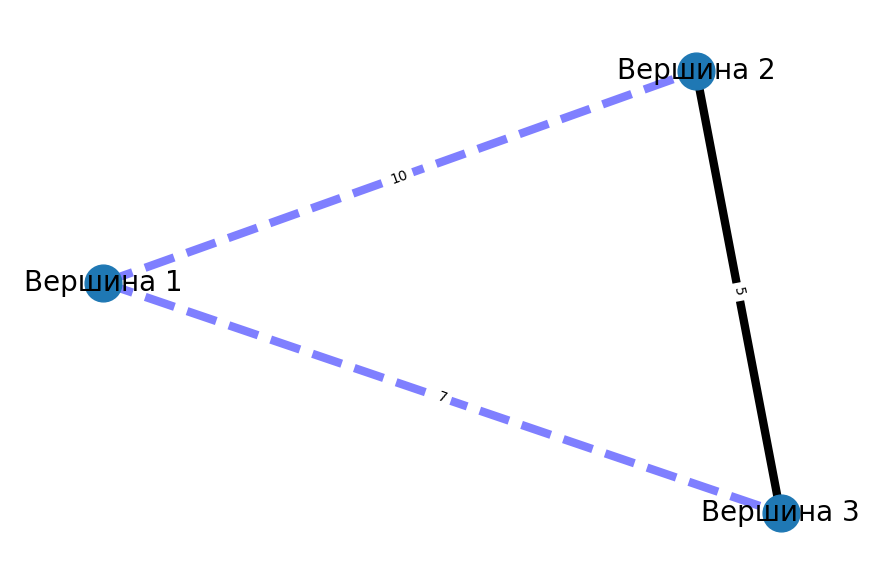

In [3]:
# Визуализация графа
plt.figure(figsize=(9,6))
elarge = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] <= 5]
esmall = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] > 5]

pos = nx.spring_layout(Battle, seed=7)

# nodes
nx.draw_networkx_nodes(Battle, pos, node_size=700)

# edges
nx.draw_networkx_edges(Battle, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    Battle, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(Battle, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(Battle, "weight")
nx.draw_networkx_edge_labels(Battle, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
t_of_simulation = 0
t_of_simulation_end = 5

t_history = []
for node in Battle.nodes():
    Battle.nodes[node]['history_N_1'] = []
    Battle.nodes[node]['history_N_2'] = []

list_of_retreats = []
list_of_reinforces = []

while (t_of_simulation<t_of_simulation_end) and (all(list(nx.get_node_attributes(Battle, 'was_retreat_1').values())) != True) and (all(list(nx.get_node_attributes(Battle, 'was_retreat_2').values())) != True):
    for node in Battle.nodes():
        if Battle.nodes[node]['was_reinforce'] == False and Battle.nodes[node]['was_retreat_1'] == True:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat_1'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_2'] = Battle.nodes[closest_node]['history_N_2'][-1]
                Battle.nodes[closest_node]['N_1'] = Battle.nodes[closest_node]['history_N_1'][-1]
                Battle.nodes[node]['N_2'] = Battle.nodes[node]['history_N_2'][-1]
                Battle.nodes[closest_node]['N_2'] += Battle.nodes[node]['N_2']
                for nodd in Battle.nodes():
                    if nodd!=node and nodd!=closest_node:
                        Battle.nodes[nodd]['N_2'] = Battle.nodes[nodd]['history_N_2'][-1]
                        Battle.nodes[nodd]['N_1'] = Battle.nodes[nodd]['history_N_1'][-1]
                # Battle.nodes[closest_node]['N_20'] = Battle.nodes[closest_node]['N_2']
                # Battle.nodes[closest_node]['a_2'] = (Battle.nodes[node]['a_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['a_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                # Battle.nodes[closest_node]['analytical_solution_2'] = Battle.nodes[closest_node]['a_2'] * Battle.nodes[closest_node]['N_20']/Battle.nodes[closest_node]['N_10']
                # Battle.nodes[closest_node]['N_for_retreat_2'] = (Battle.nodes[node]['N_for_retreat_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['N_for_retreat_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                
                Battle.nodes[node]['was_reinforce'] = True
                list_of_reinforces.append([t_history[-1], node, closest_node, 'Сторона 2'])    

        if Battle.nodes[node]['was_reinforce'] == False and Battle.nodes[node]['was_retreat_2'] == True:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat_2'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_1'] = Battle.nodes[closest_node]['history_N_1'][-1]
                Battle.nodes[closest_node]['N_2'] = Battle.nodes[closest_node]['history_N_2'][-1]
                Battle.nodes[node]['N_1'] = Battle.nodes[node]['history_N_1'][-1]
                Battle.nodes[closest_node]['N_1'] += Battle.nodes[node]['N_1']
                for nodd in Battle.nodes():
                    if nodd!=node and nodd!=closest_node:
                        Battle.nodes[nodd]['N_2'] = Battle.nodes[nodd]['history_N_2'][-1]
                        Battle.nodes[nodd]['N_1'] = Battle.nodes[nodd]['history_N_1'][-1]
                # Battle.nodes[closest_node]['N_10'] = Battle.nodes[node]['N_1']
                # Battle.nodes[closest_node]['a_1'] = (Battle.nodes[node]['a_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['a_1']*Battle.nodes[closest_node]['N_1'])/( Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
                # Battle.nodes[closest_node]['analytical_solution_1'] = Battle.nodes[closest_node]['a_1'] * Battle.nodes[closest_node]['N_10']/Battle.nodes[closest_node]['N_20']
                # Battle.nodes[closest_node]['N_for_retreat_1'] = (Battle.nodes[node]['N_for_retreat_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['N_for_retreat_1']*Battle.nodes[closest_node]['N_1'])/(Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
               
                Battle.nodes[node]['was_reinforce'] = True
                list_of_reinforces.append([t_history[-1], node, closest_node, 'Сторона 1'])

    
    t_analytical = np.arange(0, t_of_simulation_end, 1e-3)
    for node in Battle.nodes():
        if Battle.nodes[node]['was_retreat_1'] == False and Battle.nodes[node]['was_retreat_2'] == False:
            N_1_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(Battle.nodes[node]['analytical_solution_1'] - Battle.nodes[node]['analytical_solution_2'] * np.e**(-(Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical))*Battle.nodes[node]['N_1']
            N_2_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(np.e**((Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical)*Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])* Battle.nodes[node]['N_2']
        else:
            N_1_analytical = np.zeros_like(t_analytical)
            N_2_analytical = np.zeros_like(t_analytical)
        t_for_retreat_1, t_for_retreat_2 = t_of_simulation_end, t_of_simulation_end
        if Battle.nodes[node]['was_retreat_1'] == False and Battle.nodes[node]['was_retreat_2'] == False:
            for i in range(len(N_1_analytical)):
                if N_1_analytical[i] <= Battle.nodes[node]['N_for_retreat_1']:
                    t_for_retreat_1, index_retreat_1 = t_analytical[i], i
                    break
            for i in range(len(N_2_analytical)):
                if N_2_analytical[i] <= Battle.nodes[node]['N_for_retreat_2']:
                    t_for_retreat_2, index_retreat_2 = t_analytical[i], i
                    break
            if t_for_retreat_1<t_for_retreat_2:
                t_for_retreat = t_for_retreat_1
                index_retreat = index_retreat_1
                side_of_retreat = 'Сторона 1'
            else:
                t_for_retreat = t_for_retreat_2
                index_retreat = index_retreat_2
                side_of_retreat = 'Сторона 2'
        else:
            t_for_retreat = t_of_simulation_end
            index_retreat = len(t_analytical)
            side_of_retreat = 'Nan'
        Battle.nodes[node]['t_for_retreat'] = t_for_retreat
        Battle.nodes[node]['index_retreat'] = index_retreat
        Battle.nodes[node]['side_of_retreat'] = side_of_retreat

    
    min_t = min(nx.get_node_attributes(Battle, 't_for_retreat').values())
    for node in Battle.nodes():
        if Battle.nodes[node]['t_for_retreat'] == min_t:
            if  Battle.nodes[node]['side_of_retreat'] == 'Сторона 1':
                Battle.nodes[node]['was_retreat_1'] = True
            else:
                Battle.nodes[node]['was_retreat_2'] = True
        else:
            continue

    t_of_next_step = min_t + t_of_simulation
    min_nodes = [node for node, value in nx.get_node_attributes(Battle, 't_for_retreat').items() if value == min_t]
    list_of_retreats.append([min_t, min_nodes[0], Battle.nodes[min_nodes[0]]['side_of_retreat']])

    for node in Battle.nodes():
        t_analytical = np.arange(0, min_t, 1e-3)
        N_1_analytical = np.zeros_like(t_analytical)
        N_2_analytical = np.zeros_like(t_analytical)
        if Battle.nodes[node]['was_reinforce'] == True:
            Battle.nodes[node]['history_N_1'].extend(N_1_analytical)
            Battle.nodes[node]['history_N_2'].extend(N_2_analytical)
        else:
            N_1_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(Battle.nodes[node]['analytical_solution_1'] - Battle.nodes[node]['analytical_solution_2'] * np.e**(-(Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical))*Battle.nodes[node]['N_1']
            Battle.nodes[node]['history_N_1'].extend(N_1_analytical)
            N_2_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(np.e**((Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical)*Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])* Battle.nodes[node]['N_2']
            Battle.nodes[node]['history_N_2'].extend(N_2_analytical)
            
    t_history.extend(t_analytical+t_of_simulation)
    t_of_simulation = t_of_next_step

Переброска войск
Время // Откуда // Куда // Строна

In [5]:
list_of_reinforces

[[0.773, 'Вершина 1', 'Вершина 3', 'Сторона 1'],
 [0.997, 'Вершина 2', 'Вершина 3', 'Сторона 1']]

Время окончания симуляции

In [6]:
t_history[-1]

1.403

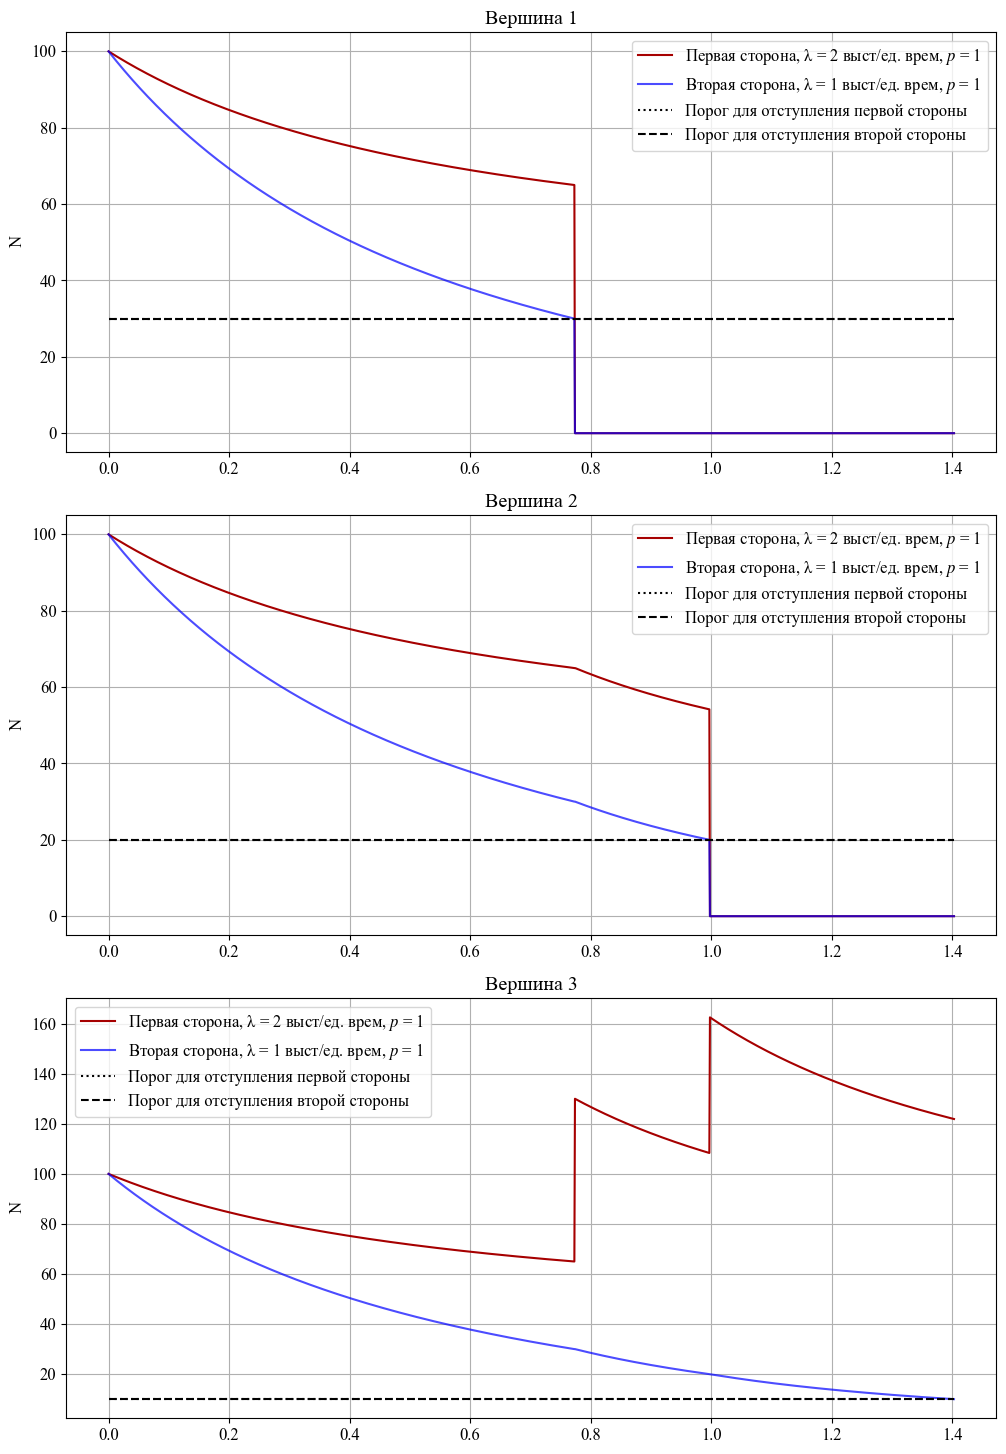

In [7]:
plt.figure(figsize=(12, len(Battle.nodes())*6))
subplots_adjust(hspace=0.15)

for v, node in enumerate(Battle.nodes()):
    ax1 = subplot(len(Battle.nodes()),1,v+1)
    ax1.set_title('{}'.format(node))
    ax1.plot(t_history, Battle.nodes[node]['history_N_1'], 
             label='Первая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_1'], 
                                                                           Battle.nodes[node]['p_1']), 
             color='#A60000')
    ax1.plot(t_history, Battle.nodes[node]['history_N_2'], 
             label='Вторая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_2'], 
                                                                           Battle.nodes[node]['p_2']), 
             color='blue', alpha=0.7)
    
    ax1.plot([t_history[0], t_history[-1]], [Battle.nodes[node]['N_for_retreat_1'], 
                                     Battle.nodes[node]['N_for_retreat_1']], 
             linestyle=':', color='black', label='Порог для отступления первой стороны')
    ax1.plot([t_history[0], t_history[-1]], [Battle.nodes[node]['N_for_retreat_2'], 
                                     Battle.nodes[node]['N_for_retreat_2']], 
             linestyle='--', color='black', label='Порог для отступления второй стороны')
    
    ax1.set_ylabel('N')
    ax1.grid()
    ax1.legend()

## Проверка с аналитическим решением

In [8]:
# Значения в трех вершинах в момент времени 0.773
N1_first = 100 * 1/(2-np.e**(-0.773))
N2_first = 100 * 1/(2*np.e**(0.773)-1)
N1_first, N2_first

(65.00370338312487, 30.00740676624974)

In [9]:
# Значения во второй вершине в момент времени 0.997
N1_second = N1_first * 1/(2-np.e**(-(0.997-0.773)))
N2_second = N2_first * 1/(2*np.e**((0.997-0.773))-1)
N1_second, N2_second

(54.13885461859555, 19.976411011763094)

In [10]:
# Значения в третьей вершине в момент времени 0.997
N1_third_between_reinforcements = (N1_first + N1_first) * 1/(2-np.e**(-(0.997-0.773)))
N2_third_between_reinforcements = N2_first * 1/(2*np.e**((0.997-0.773))-1)
N1_third_between_reinforcements, N2_third_between_reinforcements

(108.2777092371911, 19.976411011763094)

In [11]:
# Значения в третьей вершине в момент времени 1.403
N1_third = (N1_third_between_reinforcements + N1_second) * 1/(2-np.e**(-(1.403-0.997)))
N2_third = N2_third_between_reinforcements * 1/(2-np.e**(-(1.403-0.997)))
N1_third, N2_third

(121.77986207047081, 14.97830344345676)

## Пример графа с произвольным количеством вершин

In [51]:
# Создание графа
Battle = nx.Graph()

n = 5 # Количество вершин

# Задание параметров вершин с нормальным распределением
mean_lamda_1 = 1.5
std_lamda_1 = 0.2
mean_lamda_2 = 1.55
std_lamda_2 = 0.2

mean_p_1 = 0.6
std_p_1 = 0.05
mean_p_2 = 0.6
std_p_2 = 0.05

mean_N_10 = 100
std_N_10 = 3
mean_N_20 = 100
std_N_20 = 3

mean_casualties_lvl_1 = 0.3
std_casualties_lvl_1 = 0.05
mean_casualties_lvl_2 = 0.3
std_casualties_lvl_2 = 0.05

node_list = []
for i in range(n):
    node_list.append('Вершина {}'.format(i+1))
    Battle.add_node('Вершина {}'.format(i+1), 
                    lamda_1 = round(np.random.normal(mean_lamda_1, std_lamda_1, 1)[0], 2), 
                    lamda_2 = round(np.random.normal(mean_lamda_2, std_lamda_2, 1)[0], 2), 
                    p_1 = round(np.random.normal(mean_p_1, std_p_1, 1)[0], 2), 
                    p_2 = round(np.random.normal(mean_p_2, std_p_2, 1)[0], 2), 
                    N_10 = round(np.random.normal(mean_N_10, std_N_10, 1)[0], 2), 
                    N_20 = round(np.random.normal(mean_N_20, std_N_20, 1)[0], 2), 
                    casualties_lvl_1 = round(np.random.normal(mean_casualties_lvl_1, std_casualties_lvl_1, 1)[0], 2), 
                    casualties_lvl_2 = round(np.random.normal(mean_casualties_lvl_2, std_casualties_lvl_2, 1)[0], 2),
                    was_retreat_1 = False,  was_retreat_2 = False, was_reinforce = False)

for i in range(len(list(combinations(node_list, 2)))):
    Battle.add_edge(list(combinations(node_list, 2))[i][0], list(combinations(node_list, 2))[i][1], weight=np.random.randint(1,10)) 
   

for node in Battle.nodes():
    Battle.nodes[node]['N_1'] = Battle.nodes[node]['N_10']
    Battle.nodes[node]['N_2'] = Battle.nodes[node]['N_20']
    
    Battle.nodes[node]['N_for_retreat_1'] = Battle.nodes[node]['N_10'] * Battle.nodes[node]['casualties_lvl_1']
    Battle.nodes[node]['N_for_retreat_2'] = Battle.nodes[node]['N_20'] * Battle.nodes[node]['casualties_lvl_2']
    
    Battle.nodes[node]['a_1'] = Battle.nodes[node]['lamda_1'] * Battle.nodes[node]['p_1']
    Battle.nodes[node]['a_2'] = Battle.nodes[node]['lamda_2'] * Battle.nodes[node]['p_2']

    Battle.nodes[node]['analytical_solution_1'] = Battle.nodes[node]['a_1'] * Battle.nodes[node]['N_10']/Battle.nodes[node]['N_20']
    Battle.nodes[node]['analytical_solution_2'] = Battle.nodes[node]['a_2'] * Battle.nodes[node]['N_20']/Battle.nodes[node]['N_10']

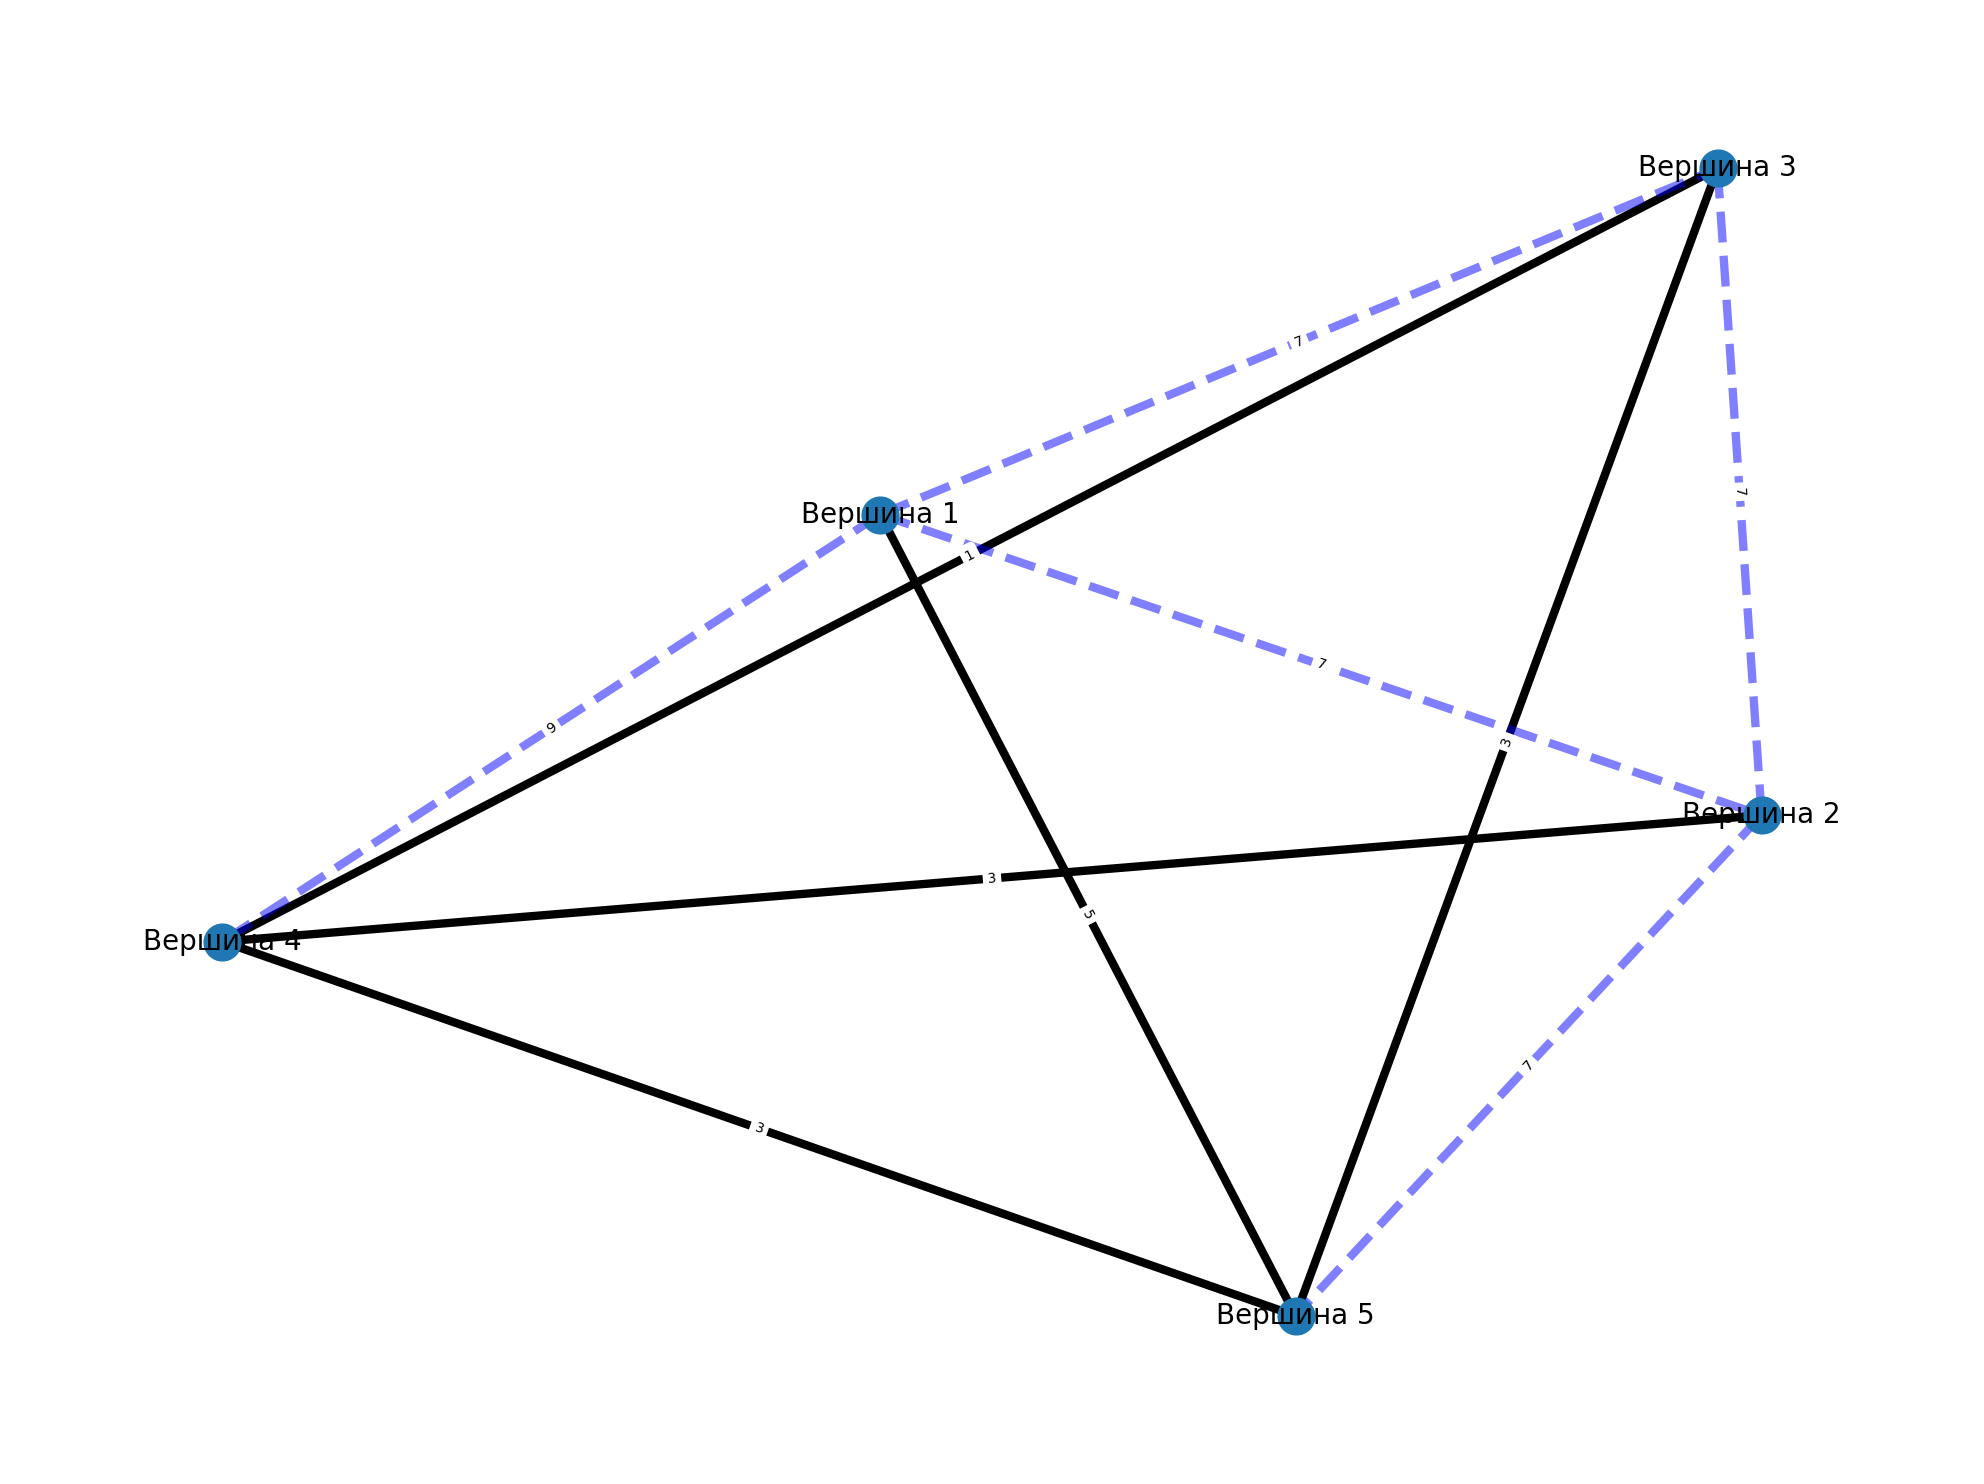

In [52]:
# Визуализация графа
plt.figure(figsize=(20,15))
elarge = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] <= 5]
esmall = [(u, v) for (u, v, d) in Battle.edges(data=True) if d["weight"] > 5]

pos = nx.spring_layout(Battle, seed=7)

# nodes
nx.draw_networkx_nodes(Battle, pos, node_size=700)

# edges
nx.draw_networkx_edges(Battle, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    Battle, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

# node labels
nx.draw_networkx_labels(Battle, pos, font_size=20, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(Battle, "weight")
nx.draw_networkx_edge_labels(Battle, pos, edge_labels)

ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

In [53]:
t_of_simulation = 0
t_of_simulation_end = 15

t_history = []
for node in Battle.nodes():
    Battle.nodes[node]['history_N_1'] = []
    Battle.nodes[node]['history_N_2'] = []

list_of_retreats = []
list_of_reinforces = []

while (t_of_simulation<t_of_simulation_end) and (all(list(nx.get_node_attributes(Battle, 'was_retreat_1').values())) != True) and (all(list(nx.get_node_attributes(Battle, 'was_retreat_2').values())) != True):
    for node in Battle.nodes():
        if Battle.nodes[node]['was_reinforce'] == False and Battle.nodes[node]['was_retreat_1'] == True:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat_2'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_2'] = Battle.nodes[closest_node]['history_N_2'][-1]
                Battle.nodes[closest_node]['N_1'] = Battle.nodes[closest_node]['history_N_1'][-1]
                Battle.nodes[node]['N_2'] = Battle.nodes[node]['history_N_2'][-1]
                Battle.nodes[closest_node]['N_2'] += Battle.nodes[node]['N_2']
                for nodd in Battle.nodes():
                    if nodd!=node and nodd!=closest_node:
                        Battle.nodes[nodd]['N_2'] = Battle.nodes[nodd]['history_N_2'][-1]
                        Battle.nodes[nodd]['N_1'] = Battle.nodes[nodd]['history_N_1'][-1]
                # Battle.nodes[closest_node]['N_20'] = Battle.nodes[closest_node]['N_2']
                # Battle.nodes[closest_node]['a_2'] = (Battle.nodes[node]['a_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['a_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                # Battle.nodes[closest_node]['analytical_solution_2'] = Battle.nodes[closest_node]['a_2'] * Battle.nodes[closest_node]['N_20']/Battle.nodes[closest_node]['N_10']
                # Battle.nodes[closest_node]['N_for_retreat_2'] = (Battle.nodes[node]['N_for_retreat_2']*Battle.nodes[node]['N_2']+Battle.nodes[closest_node]['N_for_retreat_2']*Battle.nodes[closest_node]['N_2'])/( Battle.nodes[closest_node]['N_2']+Battle.nodes[node]['N_2'])
                
                Battle.nodes[node]['was_reinforce'] = True
                list_of_reinforces.append([t_history[-1], node, closest_node, 'Сторона 2'])    

        if Battle.nodes[node]['was_reinforce'] == False and Battle.nodes[node]['was_retreat_2'] == True:
            source_node = node
            closest_node = None
            min_distance = float('inf')
            for neighbor in Battle.neighbors(source_node):
                distance = Battle[source_node][neighbor]['weight']
                if (distance < min_distance) and (Battle.nodes[neighbor]['was_retreat_1'] == False):
                    closest_node = neighbor
                    min_distance = distance
            if closest_node == None:
                pass
            else:
                Battle.nodes[closest_node]['N_1'] = Battle.nodes[closest_node]['history_N_1'][-1]
                Battle.nodes[closest_node]['N_2'] = Battle.nodes[closest_node]['history_N_2'][-1]
                Battle.nodes[node]['N_1'] = Battle.nodes[node]['history_N_1'][-1]
                Battle.nodes[closest_node]['N_1'] += Battle.nodes[node]['N_1']
                for nodd in Battle.nodes():
                    if nodd!=node and nodd!=closest_node:
                        Battle.nodes[nodd]['N_2'] = Battle.nodes[nodd]['history_N_2'][-1]
                        Battle.nodes[nodd]['N_1'] = Battle.nodes[nodd]['history_N_1'][-1]
                # Battle.nodes[closest_node]['N_10'] = Battle.nodes[node]['N_1']
                # Battle.nodes[closest_node]['a_1'] = (Battle.nodes[node]['a_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['a_1']*Battle.nodes[closest_node]['N_1'])/( Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
                # Battle.nodes[closest_node]['analytical_solution_1'] = Battle.nodes[closest_node]['a_1'] * Battle.nodes[closest_node]['N_10']/Battle.nodes[closest_node]['N_20']
                # Battle.nodes[closest_node]['N_for_retreat_1'] = (Battle.nodes[node]['N_for_retreat_1']*Battle.nodes[node]['N_1']+Battle.nodes[closest_node]['N_for_retreat_1']*Battle.nodes[closest_node]['N_1'])/(Battle.nodes[closest_node]['N_1']+Battle.nodes[node]['N_1'])
               
                Battle.nodes[node]['was_reinforce'] = True
                list_of_reinforces.append([t_history[-1], node, closest_node, 'Сторона 1'])

    
    t_analytical = np.arange(0, t_of_simulation_end, 1e-3)
    for node in Battle.nodes():
        if Battle.nodes[node]['was_retreat_1'] == False and Battle.nodes[node]['was_retreat_2'] == False:
            N_1_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(Battle.nodes[node]['analytical_solution_1'] - Battle.nodes[node]['analytical_solution_2'] * np.e**(-(Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical))*Battle.nodes[node]['N_1']
            N_2_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(np.e**((Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical)*Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])* Battle.nodes[node]['N_2']
        else:
            N_1_analytical = np.zeros_like(t_analytical)
            N_2_analytical = np.zeros_like(t_analytical)
        t_for_retreat_1, t_for_retreat_2 = t_of_simulation_end - t_of_simulation, t_of_simulation_end - t_of_simulation
        if Battle.nodes[node]['was_retreat_1'] == False and Battle.nodes[node]['was_retreat_2'] == False:
            for i in range(len(N_1_analytical)):
                if N_1_analytical[i] <= Battle.nodes[node]['N_for_retreat_1']:
                    t_for_retreat_1, index_retreat_1 = t_analytical[i], i
                    break
            for i in range(len(N_2_analytical)):
                if N_2_analytical[i] <= Battle.nodes[node]['N_for_retreat_2']:
                    t_for_retreat_2, index_retreat_2 = t_analytical[i], i
                    break
            if t_for_retreat_1<t_for_retreat_2:
                t_for_retreat = t_for_retreat_1
                index_retreat = index_retreat_1
                side_of_retreat = 'Сторона 1'
            else:
                t_for_retreat = t_for_retreat_2
                index_retreat = index_retreat_2
                side_of_retreat = 'Сторона 2'
        else:
            t_for_retreat = t_of_simulation_end
            index_retreat = len(t_analytical)
            side_of_retreat = 'Nan'
        Battle.nodes[node]['t_for_retreat'] = t_for_retreat
        Battle.nodes[node]['index_retreat'] = index_retreat
        Battle.nodes[node]['side_of_retreat'] = side_of_retreat

    
    min_t = min(nx.get_node_attributes(Battle, 't_for_retreat').values())
    for node in Battle.nodes():
        if Battle.nodes[node]['t_for_retreat'] == min_t:
            if  Battle.nodes[node]['side_of_retreat'] == 'Сторона 1':
                Battle.nodes[node]['was_retreat_1'] = True
            else:
                Battle.nodes[node]['was_retreat_2'] = True
        else:
            continue

#    print(min_t + t_of_simulation, min_t, all(list(nx.get_node_attributes(Battle, 'was_retreat_1').values())), all(list(nx.get_node_attributes(Battle, 'was_retreat_2').values())))
    t_of_next_step = min_t + t_of_simulation
    min_nodes = [node for node, value in nx.get_node_attributes(Battle, 't_for_retreat').items() if value == min_t]
    list_of_retreats.append([min_t, min_nodes[0], Battle.nodes[min_nodes[0]]['side_of_retreat']])
    for node in Battle.nodes():
        t_analytical = np.arange(0, min_t, 1e-3)
        N_1_analytical = np.zeros_like(t_analytical)
        N_2_analytical = np.zeros_like(t_analytical)
        if Battle.nodes[node]['was_reinforce'] == True:
            Battle.nodes[node]['history_N_1'].extend(N_1_analytical)
            Battle.nodes[node]['history_N_2'].extend(N_2_analytical)
        else:
            N_1_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(Battle.nodes[node]['analytical_solution_1'] - Battle.nodes[node]['analytical_solution_2'] * np.e**(-(Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical))*Battle.nodes[node]['N_1']
            Battle.nodes[node]['history_N_1'].extend(N_1_analytical)
            N_2_analytical = (Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])/(np.e**((Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])*t_analytical)*Battle.nodes[node]['analytical_solution_1']-Battle.nodes[node]['analytical_solution_2'])* Battle.nodes[node]['N_2']
            Battle.nodes[node]['history_N_2'].extend(N_2_analytical)
            
    t_history.extend(t_analytical+t_of_simulation)
    t_of_simulation = t_of_next_step



index_arr_2 = []
for node in Battle.nodes():
    index_for_cut = 0
    for i in range(len(Battle.nodes[node]['history_N_2'])):
        if Battle.nodes[node]['history_N_2'][i] == 0:
            index_for_cut = i
            index_arr_2.append(i)
            break
max_index = max(index_arr_2)

t_history = t_history[:max_index]
for node in Battle.nodes():
    Battle.nodes[node]['history_N_1'] = Battle.nodes[node]['history_N_1'][:max_index]
    Battle.nodes[node]['history_N_2'] = Battle.nodes[node]['history_N_2'][:max_index]

Переброска войск

Время // Откуда // Куда // Строна

In [54]:
list_of_reinforces

[[1.288, 'Вершина 5', 'Вершина 3', 'Сторона 2'],
 [1.293, 'Вершина 1', 'Вершина 2', 'Сторона 1'],
 [1.5429999999999997, 'Вершина 4', 'Вершина 3', 'Сторона 1'],
 [2.726, 'Вершина 3', 'Вершина 4', 'Сторона 1'],
 [2.779, 'Вершина 2', 'Вершина 4', 'Сторона 1']]

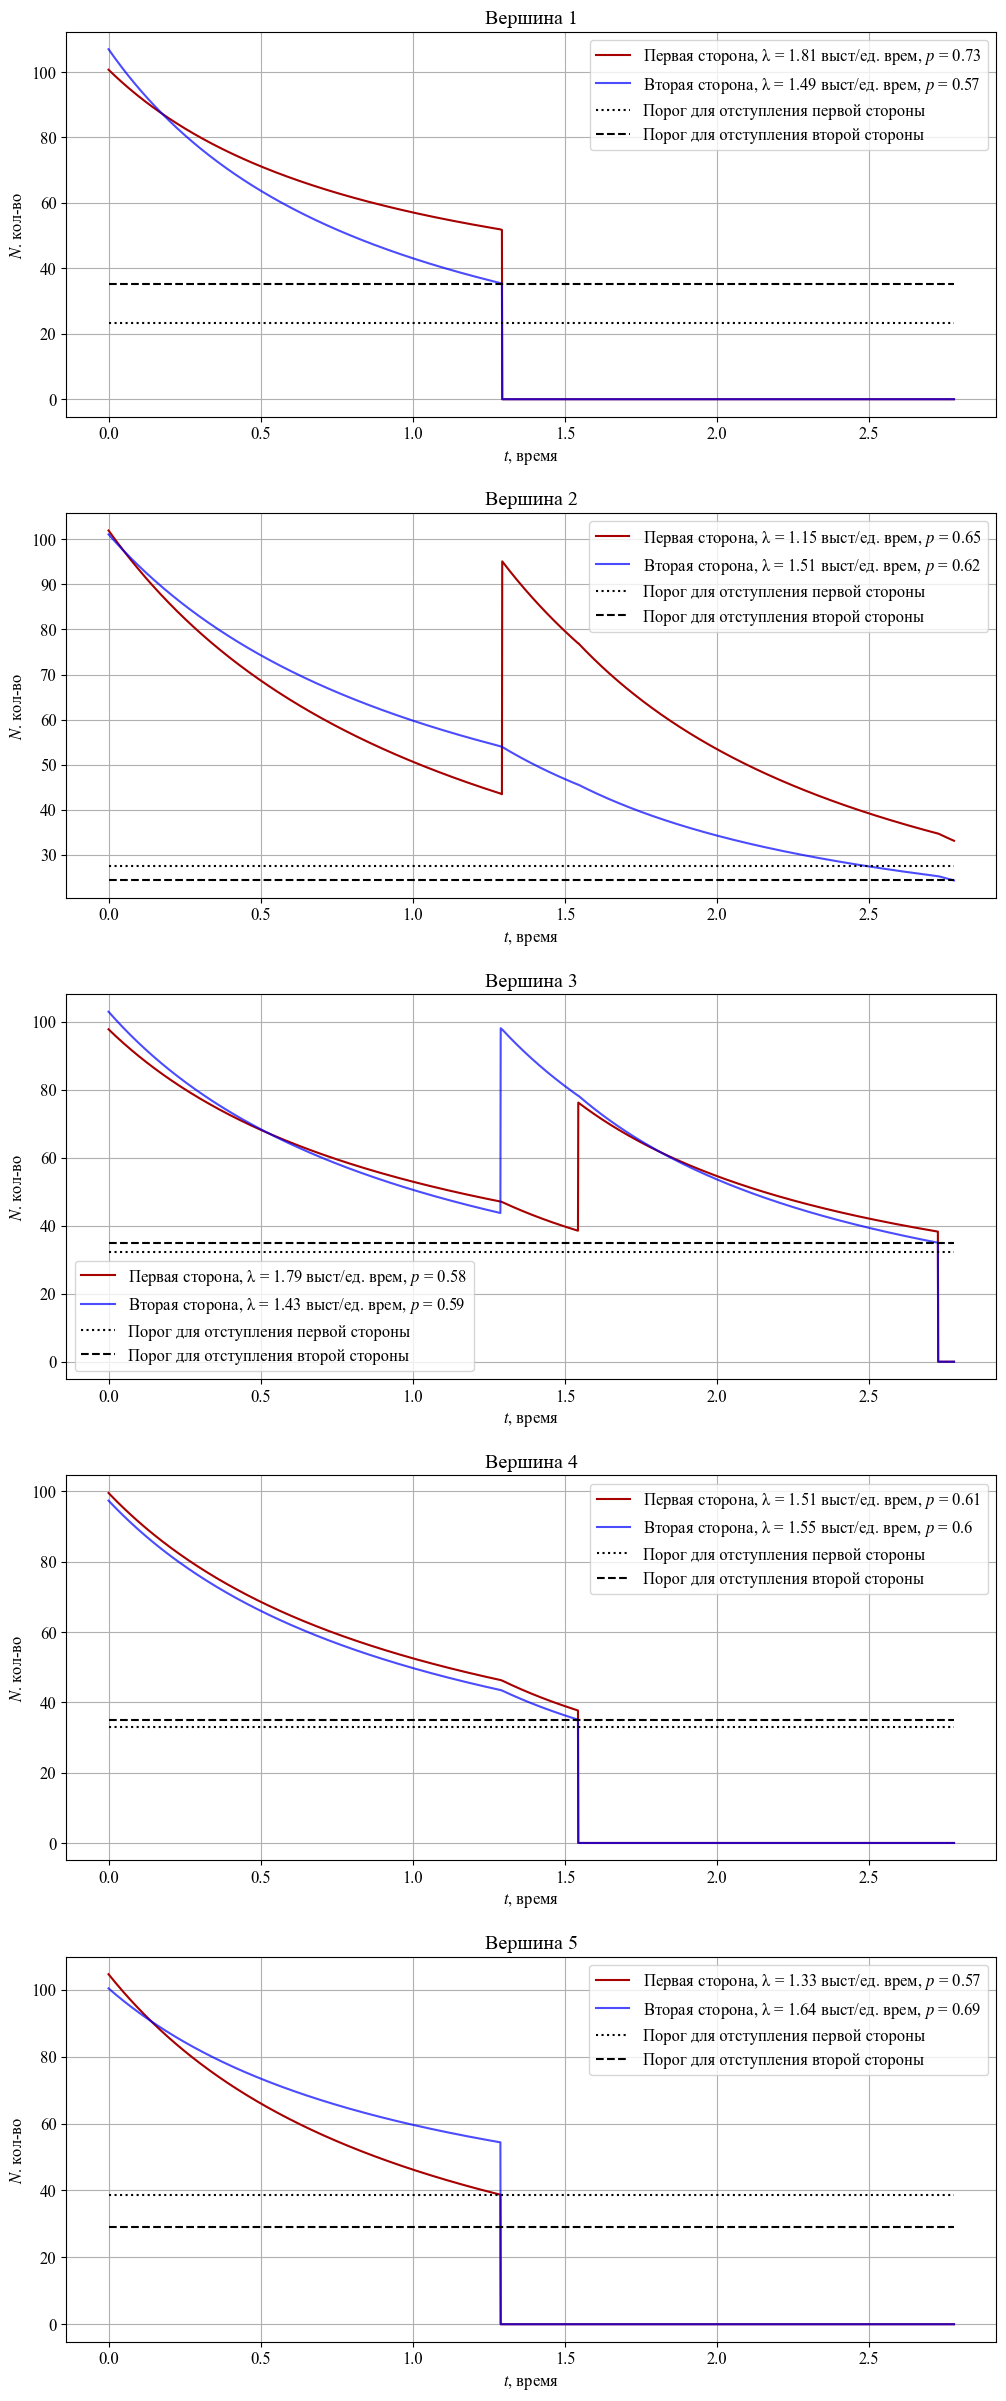

In [55]:
plt.figure(figsize=(12, len(Battle.nodes())*6))
subplots_adjust(hspace=0.25)

for v, node in enumerate(Battle.nodes()):
    ax1 = subplot(len(Battle.nodes()),1,v+1)
    ax1.set_title('{}'.format(node))
    ax1.plot(t_history, Battle.nodes[node]['history_N_1'], 
             label='Первая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_1'], 
                                                                           Battle.nodes[node]['p_1']), 
             color='#A60000')
    ax1.plot(t_history, Battle.nodes[node]['history_N_2'], 
             label='Вторая сторона, λ = {} выст/ед. врем, $p$ = {}'.format(Battle.nodes[node]['lamda_2'], 
                                                                           Battle.nodes[node]['p_2']), 
             color='blue', alpha=0.7)
    
    ax1.plot([t_history[0], t_history[-1]], [Battle.nodes[node]['N_for_retreat_1'], 
                                     Battle.nodes[node]['N_for_retreat_1']], 
             linestyle=':', color='black', label='Порог для отступления первой стороны')
    ax1.plot([t_history[0], t_history[-1]], [Battle.nodes[node]['N_for_retreat_2'], 
                                     Battle.nodes[node]['N_for_retreat_2']], 
             linestyle='--', color='black', label='Порог для отступления второй стороны')
    
    ax1.set_ylabel('$N$. кол-во')
    ax1.set_xlabel('$t$, время')
    ax1.grid()
    ax1.legend()